Create an agent that works efficiently for our company! We spend too much time drafting documents and this needs to be fixed!

For the company, you need to create an AI Agentic System that can speed up drafting documents, emails, etc. 
The AI Agentic System should have Human-AI Collaboration meaning the Human should provide continuous feedback and the AI Agent should stop when the Human is happy with the draft. The system should be fast and save the drafts.  

The agent should follow this diagram

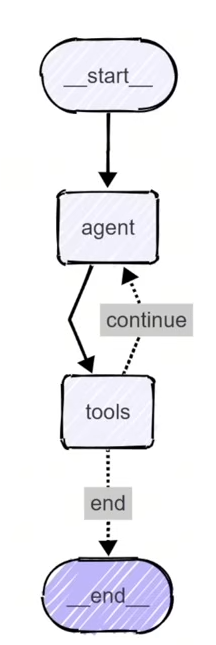

In [16]:
from IPython.display import Image, display

display(Image(filename='imgs/04_draft_agent.png'))

The difference between this agent and the React agent is that in this case, the agent finishes right after using the tool

In [17]:
from typing import TypedDict, List, Annotated, Sequence 

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI


from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_GENAI_API_TOKEN")

The right way to pass in a state in tools is to inject state but since it's not covered in the scope of the course. We will use a global variable instead

In [19]:
document_content = ""



In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [21]:
@tool
def update(content:str) -> str:
    """Update the doc with the provided content"""

    global document_content
    document_content = content
    return f"The document has been updated succesfully! The current content is:\n {document_content}"

In [22]:
@tool
def save(filename:str) -> str:
    """
    Save the current doc to a text file and finish the process
    
    Args: 
        filename: name for the text file
    """
    global document_content
    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"

    try:
        with open(filename, "w") as f:
            f.write("Your conversation log:\n")
        print(f"\n Document has been saved to: {filename}")
        return f"Document has been save succesfully to '{filename}'."
    
    except Exception as e:
        return f"Error saving the doc {str(e)}"
    
    
    

In [23]:
tools = [update,save]

In [24]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  
    temperature=0,
    google_api_key=GOOGLE_API_KEY
).bind_tools(tools)

In [25]:
def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{document_content}
    """)

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = llm.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}

In [26]:

def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    # reversed() is a function to run a sequence in inverse order
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        # isinstance(obj, class _or_tuple_class) verifies the object and returns True or False
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"

In [27]:
def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")




In [28]:


graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()

In [29]:
def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")


In [ ]:
if __name__ == "__main__":
    run_document_agent()


 ===== DRAFTER =====

🤖 AI: Okay, I'm ready. Let's start with a simple document. How about this:

"The quick brown fox jumps over the lazy dog."

👤 USER: write an e-mail saying I cannot make it to the meeting 

🤖 AI: Okay, I can help with that. First, I need to update the current document. How about this for the updated content:

"Subject: Unable to Attend Meeting

Dear [Recipient Name],

I am writing to inform you that I will be unable to attend the meeting scheduled for [Date] at [Time] due to [Reason].

I apologize for any inconvenience this may cause. I have already [Steps taken to mitigate absence, e.g., briefed a colleague, sent materials]. I will reach out after the meeting to get an update on key discussion points and action items.

Thank you for your understanding.

Sincerely,
[Your Name]"

👤 USER: make sure the meeting time is written down. the meeting is at 10am

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: The document has been updated succesfully! The current content